# The HFM library - A fast marching solver with adaptive stencils

## Part : Custom optimal control models, discrete states
## Chapter : Dubins car with a state and additional controls

$
\def\bR{\mathbb{R}}
\def\bS{\mathbb{S}}
$

In this notebook, we implement optimal control models featuring a state. One of the target applications is a Dubins car which has additional motion controls, including the ability to move sideways to some amount and in reverse gear. This model must change state to use them, which incurs a fixed positive cost.

**Model description.** 
The configuration space is $\Omega \times \bS$, where $\Omega\subset \bR^d$ is an open domain, and $\bS :=\{0,\cdots,S-1\}$ with $S$ the number of distinct states.
At a configuration $(x,s) \in \Omega \times \bS$, the possibilities are : 
* *Continuous evolution in the physical space*  
$$
    \dot x = \omega_{ks}(x),
$$
where $\omega_{ks} : \Omega \to \bR^d$ is a given vector field, depending on an integer $0\leq k < K$ which can be chosen arbitrarily, and on the current state $0\leq s < S$. 
* *Change of state*
$$
    (x,s) \mapsto (x,s')
$$
which requires some time $T(s,s')$, given by state transition cost matrix. 

**Input format.**
* *Physical controls :* if $\Omega$ is discretized on a grid of shape $(n_1,..,n_d)$, then the control fields $(\omega_{ks}(x))$ must be given as an array of shape
$$
    (K,d,n_{r+1},\cdots,n_d,S),
$$
where $0\leq r \leq d$ is arbitrary. If $r\neq 0$, then the control fields are automatically broadcasted $\omega_{ks}(x) = \omega_{ks}(x_{r+1},\cdots,x_d)$.
* *State transitions :* given as a matrix of shape $S\times S$ with zeros on the diagonal.


**Limitations of the proposed implementation.**
* The number of states is limited to respectively $\#(S)=2, 4, 7$, when the physical dimension equals $d=1,2,3$ respectively. 
* The number $K$ of controls is independent of the state $s\in S$. Please add zero controls $\omega_s^k\equiv 0$ if this does not fit your model.
* The state transition cost $T(s,s')$ is independent of the current position $x$.
* Only the GPU eikonal solver implements this model.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. One dimensional models](#1.-One-dimensional-models)
    * [1.1 Single state, constant control](#1.1-Single-state,-constant-control)
    * [1.2 Single state, variable control](#1.2-Single-state,-variable-control)
    * [1.3 Two states, single control](#1.3-Two-states,-single-control)
    * [1.4 Two states, two controls per state.](#1.4-Two-states,-two-controls-per-state.)
  * [2. The Dubins model](#2.-The-Dubins-model)
    * [2.1 Reproducing the standard Dubins car](#2.1-Reproducing-the-standard-Dubins-car)
    * [2.2 A Dubins car with a reverse gear, and a fast forward gear](#2.2-A-Dubins-car-with-a-reverse-gear,-and-a-fast-forward-gear)
    * [2.3 A Dubins car with sideways motions](#2.3-A-Dubins-car-with-sideways-motions)
    * [2.4 Illustration with walls](#2.4-Illustration-with-walls)
  * [3. Staying away from the walls](#3.-Staying-away-from-the-walls)
    * [3.1 Computing the obstacles and their distance](#3.1-Computing-the-obstacles-and-their-distance)
    * [3.2 Running the eikonal solver](#3.2-Running-the-eikonal-solver)
    * [3.3 Yet another model](#3.3-Yet-another-model)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

# 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if agd package installed)

In [2]:
from agd import Eikonal 
from agd import AutomaticDifferentiation as ad
from agd import Plotting

In [3]:
import numpy as np; xp = np
from matplotlib import pyplot as plt

### 0.1 Additional configuration

**Running and viewing the notebook**
* *Static viewing.* If you are looking at this notebook using nbviewer, but see an error in the following cell, then [try this link instead](https://nbviewer.org/urls/dl.dropbox.com/s/qbkt9hdhrnrpwtr/DubinsState.ipynb).
* *Running.* A cuda enabled GPU is needed to run this notebook. If you do not have one, try [running it on Google Colab](https://drive.google.com/file/d/1-bxfUthYYId6ZC6NXDatNDC6vc6mACKs/view?usp=sharing).

In [4]:
try: import cupy
except ModuleNotFoundError: raise ad.DeliberateNotebookError("A cuda enabled gpu is required for this notebook")

In [5]:
xp,plt,Eikonal = map(ad.cupy_friendly,(xp,plt,Eikonal))

Replacing numpy with cupy, set to output 32bit ints and floats by default.
Using cp.asarray(*,dtype=np.float32) as the default caster in ad.array.
Returning a copy of module matplotlib.pyplot whose functions accept cupy arrays as input.
Setting dictIn.default_mode = 'gpu' in module agd.Eikonal .


### 0.2 Utility function

In [6]:
def control_source(activeNeighs,ncontrols,control_default=np.nan,source_default=np.nan):
    """
    Returns the optimal control, or the source of the optimal jump, at each point reached 
    by the front.
    Input : 
     - activeNeighs : produced by the eikonal solver, with option 'exportActiveNeighs':True
     - ncontrols : number of controls of the model (needed in case of several states)
     - control default : when no control is used (jump to another state, or stationnary point)
     - jump default : when no jump is done (following a control vector, or stationnary point)
    Output : 
     - control : the index of the control used
     - source (only if several states) : the index of the source state of the jump
    """
    nstates = activeNeighs.shape[-1]
    ndim = activeNeighs.ndim
    decompdim = (ndim*(ndim-1))//2
    active = activeNeighs%(2**decompdim)
    stationnary = (active==0) # No control used. Seeds and non reachable points (e.g. inside walls)
    control = np.where(stationnary,control_default,activeNeighs//(2**decompdim)) 
    assert np.all(control[~stationnary]<ncontrols+(nstates>1))
    if nstates==1: return control # Model with a single state
    jump = (~stationnary) & (control==ncontrols) # Points where the optimal option is to jump to a different state
    source = np.log2(active).round().astype(int) # source of the jump
    source = np.where(jump,source + (source>=xp.arange(nstates)), source_default)
    return np.where(control==ncontrols,control_default,control),source

## 1. One dimensional models

In order to introduce the DubinsState model, we first illustrate it in one physical space dimension $d=1$.

### 1.1 Single state, constant control

The problem is here posed on the domain $\Omega \times S$, where $\Omega = ]a,b[$ and $S = \{0\}$.
The front propagation starts from the seed $x_0\in \Omega$. 

<!---
, and a geodesic is backtracked from $x_1\in \Omega$.

'exportGeodesicFlow':True, # Save the upwind gradient of the solution to the eikonal equation

Save which neighbors of the finite difference stencil are active

The geodesic flow, which is the negative gradient of the solution to the eikonal equation, allows us infer the optimal control used at each point. The shape is 
$$
    (d+1,n_1,\cdots,n_d,r).
$$

flow = hfmOut['flow']
print(f"{flow.shape=}")

The last component is nonzero only when there is a state transition.

assert np.allclose(flow[-1],0)

The $d$ first components should (approximately) match one of the control vectors of the current state, namely the optimal one for the present configuration. (Here $d=1$)

plt.title("Geodesic flow")
plt.plot(X,flow[0]);
--->


In [7]:
a,b,x0 = 0,1,0.4 # Endpoints of Ω, propagation seed
Nx = 100 # Number of discretization points in Ω

hfmIn = Eikonal.dictIn({
    # The 2 refers to 1 physical dimension plus 1 dimension for the states.
    'model':'DubinsState2', 
    'speed':1, # Please leave as is
    'seed':(x0,0), # Start at position x0, with state 0
    'tips':[(0.8,0),(0.1,0)], # Backtrack geodesic from these points. Note state 0.
    'dims':(Nx,1), # Nx discretization points for the physical domain, one for the state
    'origin':(a,-0.5), # Origin of the domain Ω, please leave as is the second component.
    'gridScales':((b-a)/Nx,1), # Gridscale within Ω, please leave as is the second component.

     # State transitions are irrelevant for a single state, but this input is expected nevertheless.
    'state_transition_costs':[[0]],
    
    'exportValues':True, # Save the solution to the eikonal equation
    'exportActiveNeighs':True, # Data used to get the optimal control and jump target
    })

In [8]:
X,S = hfmIn.Axes()
print(f"Set of states : {S=}")

Set of states : S=array([0.], dtype=float32)


We consider a vehicle with a single state, and two controls which do not depend on the current point.

In [9]:
ω00 = (2,) # Move at speed two to the right
ω10 = (-1,) # Move at speed one to the left

Recall that the controls must be provided as an array of shape $(K,d,n_{r+1},\cdots,n_d,S)$.
In this specific case 
* $K=2$ (two controls)
* $d=1$ (one space dimension) 
* $r=d$ (the controls are independent of the physical position), 
* $S=1$ (a single state)

In [10]:
hfmIn['controls'] = xp.asarray((ω00,ω10),dtype=np.float32)[...,np.newaxis] 
print(f"{hfmIn['controls'].shape=}")

hfmIn['controls'].shape=(2, 1, 1)


In [11]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.010996580123901367 seconds, and 6 iterations.
Post-Processing


As expected, the vehicle travels twice faster to the right than to the left.

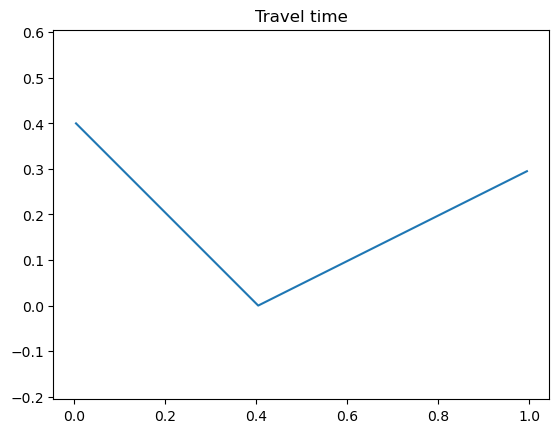

In [12]:
plt.title("Travel time")
plt.plot(X,hfmOut['values'])
plt.axis('equal');

We show below the index $k$ of the optimal control $\omega_{k0}$, at each point in the domain. Recall that that the vehicle states from the seed, and follows the controls:
* $k=-1$: default value at the seed.
* $k=0$: $\omega_{00}$ moves to the right,
* $k=1$: $\omega_{10}$ moves to the left.

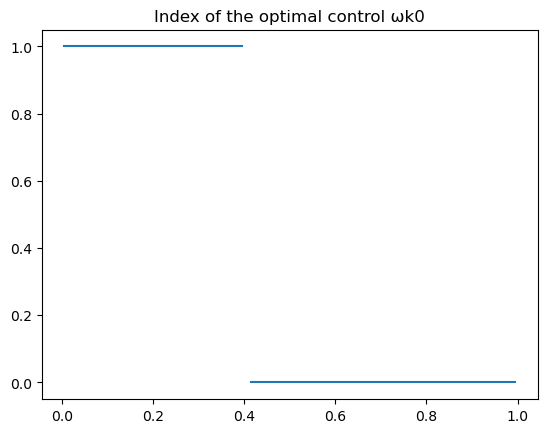

In [13]:
plt.title("Index of the optimal control ωk0")
optimal_control = control_source(hfmOut['activeNeighs'],len(hfmIn['controls']))
plt.plot(X,optimal_control.squeeze(-1));

The two backtracked geodesics go straight to the seed.

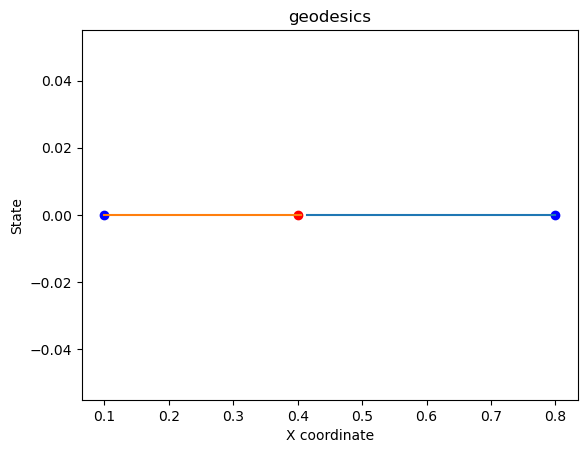

In [14]:
plt.title('geodesics')
plt.xlabel('X coordinate')
plt.ylabel('State')
plt.scatter(*hfmIn['seed'],color='red')
plt.scatter(*hfmIn['tips'].T,color='blue')
for geo in hfmOut['geodesics']: plt.plot(*geo)

### 1.2 Single state, variable control

We consider a control which depends on the current position $x$.

<!---
plt.title("Geodesic flow")
plt.plot(X,hfmOut['flow'][0],label="flow")
plt.legend();

plt.title('Available controls')
plt.plot(X,ω00,label="ω00")
plt.plot(X,ω10,label="ω10")
plt.plot(X,ω20,label="ω20")
plt.legend();
--->

In [15]:
one = np.ones_like(X)
ω00 =  2*one # Move at speed two to the right
ω10 = -1*one # Move at speed one to the left
ω20 =  4*(X-0.5) # A control depending on the position X

We stack the controls, respecting the format $(K,d,n_{r+1},\cdots,n_d,S)$, here with $K=3$, $d=1$, $r=0$, $S=0$.

In [16]:
hfmIn['controls'] = xp.asarray((ω00,ω10,ω20))[:,np.newaxis,:,np.newaxis] 
print(f"{hfmIn['controls'].shape=}")

hfmIn['controls'].shape=(3, 1, 100, 1)


In [17]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.003994464874267578 seconds, and 6 iterations.
Post-Processing


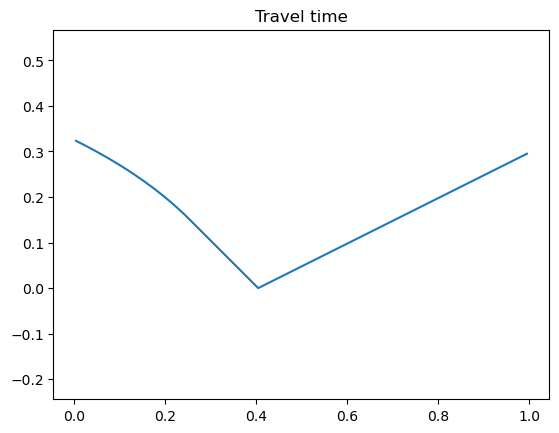

In [18]:
plt.title("Travel time")
plt.plot(X,hfmOut['values'])
plt.axis('equal');

Again, we can see which control is used on which part of the domain.

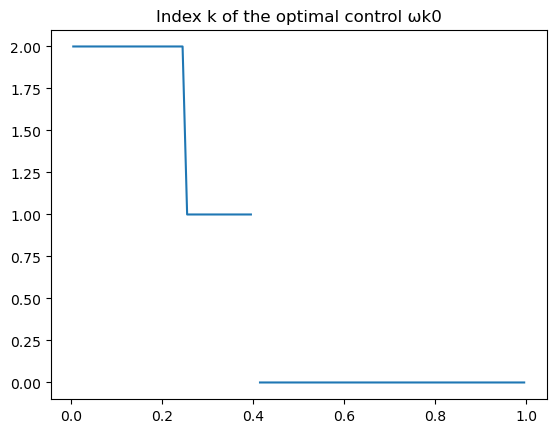

In [19]:
plt.title("Index k of the optimal control ωk0")
optimal_control = control_source(hfmOut['activeNeighs'],len(hfmIn['controls']))
plt.plot(X,optimal_control.squeeze(-1));

The geodesics are straight lines to the origin, as before.

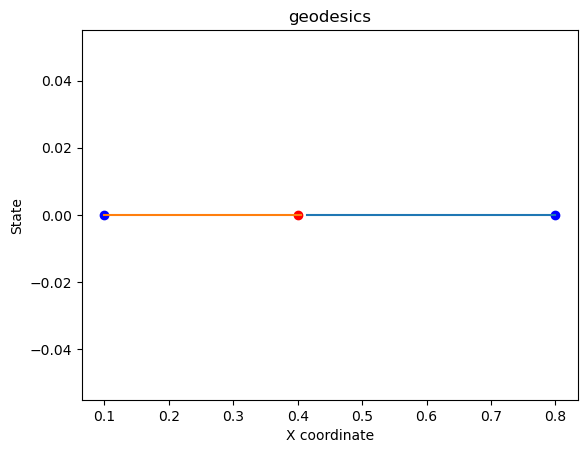

In [20]:
plt.title('geodesics')
plt.xlabel('X coordinate')
plt.ylabel('State')
plt.scatter(*hfmIn['seed'],color='red')
plt.scatter(*hfmIn['tips'].T,color='blue')
for geo in hfmOut['geodesics']: plt.plot(*geo)

### 1.3 Two states, single control

We consider a vehicle which can move forward and backward. However, switching between these two modes of operation has a cost.

In [21]:
a,b,x0 = 0,1,0.4 # Endpoints of Ω, seed point
Nx = 100 # Number of discretization points in Ω
cost_0to1, cost_1to0 = 1,2

hfmIn = Eikonal.dictIn({
    # The 2 refers to 1 physical dimension plus 1 dimension for the states.
    'model':'DubinsState2', 
    'speed':1, # Please leave as is
    'seed':(x0,0), # Start at position x0, with state 0
    'tips':[(0.8,0),(0.7,1),(0.1,1),(0.2,0)], # Geodesic tips, with various coordinates and states
    'dims':(Nx,2), # Nx discretization points for the physical domain, TWO for the state
    'origin':(a,-0.5), # Origin of the domain Ω, please leave as is the second component.
    'gridScales':((b-a)/Nx,1), # Gridscale within Ω, please leave as is the second component.

     # State transitions are irrelevant for a single state, but this input is expected nevertheless.
    'state_transition_costs':[[0,cost_1to0],[cost_0to1,0]],
    
    'exportValues':True, # Save the solution to the eikonal equation
    'exportActiveNeighs':True, # Data used to get the optimal control and jump target
    
#    'geodesic_mixed_state':True,
    })

In [22]:
X,S = hfmIn.Axes()
print(f"Set of states : {S=}")

Set of states : S=array([0., 1.], dtype=float32)


We have $K=1$ (each state has a single control), and $S=2$ (two states are available). The states are referred to as the forward (0) and backward (1) states, for obvious reasons.

In [23]:
ω00 = (2,) # Move at speed two to the right
ω01 = (-1,) # Move at speed one to the left

In [24]:
hfmIn['controls'] = xp.asarray(np.stack((ω00,ω01),axis=-1)[np.newaxis],dtype=np.float32)

In [25]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0019991397857666016 seconds, and 6 iterations.
Post-Processing


Now the value function also depends on the arrival state. Recall that we start in the forward state (0). We can distinguish four cases.
* Reach $x>x_0$, with final forward state (0). Just use the available forward control. Total time $(x-x_0)/2$.
* Reach $x>x_0$, with final backward state (1). Use the forward control, then switch to backward. Total time $1+(x-x_0)/2$.
* Reach $x<x_0$, with final backward state (1). Switch to backward, then use backward control. Total time $1+(x_0-x)$.
* Reach $x<x_0$, with final forward state (0). Switch to backward, then use backward control, then switch to forward. Total time $3+(x_0-x)$.

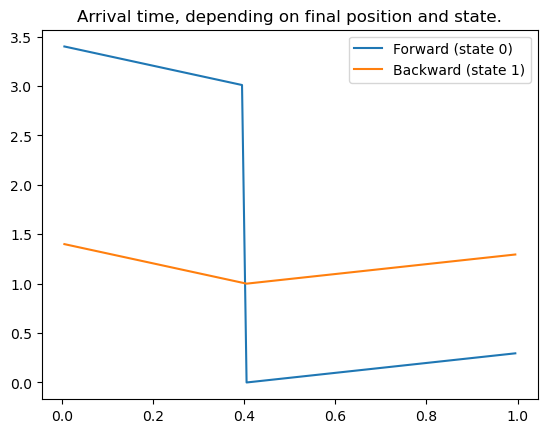

In [26]:
plt.title("Arrival time, depending on final position and state.")
plt.plot(X,hfmOut['values'],label=["Forward (state 0)","Backward (state 1)"])
plt.legend();

Note that there is only one control, for each state. Therefore, the index of the optimal control is either $k=0$ (the only available control), or $k=$NaN (no control used at this point, where a jump takes place).

Likewise the source of the optimal jump is always $1$ (resp. $0$) in state $0$ (resp. state $1$), except when the optimal action is not to jump, in which case the value NaN is returned. 

In [27]:
optimal_control,jump_source = control_source(hfmOut['activeNeighs'],len(hfmIn['controls']))

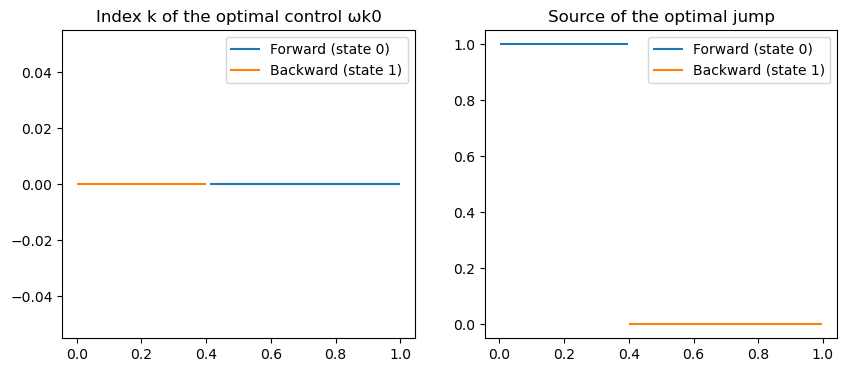

In [28]:
fig,(ax0,ax1) = plt.subplots(ncols=2,figsize=[10,4])
ax0.set_title("Index k of the optimal control ωk0")
ax0.plot(X.get(),optimal_control.get(),label=["Forward (state 0)","Backward (state 1)"])
ax0.legend()
ax1.set_title("Source of the optimal jump")
ax1.plot(X.get(),jump_source.get(),label=["Forward (state 0)","Backward (state 1)"])
ax1.legend();

The geodesics feature jumps to the correct state. Recall that the vehicle starts at the red seed point, and that state $0$ features a forward control (to the right), and state $1$ a backward control (to the left).

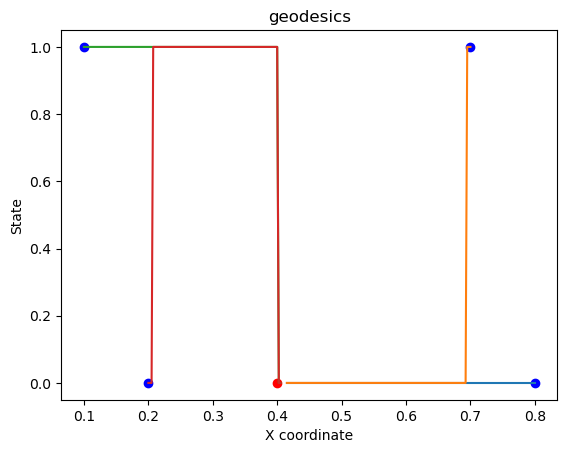

In [29]:
plt.title('geodesics')
plt.xlabel('X coordinate')
plt.ylabel('State')
plt.scatter(*hfmIn['seed'],color='red')
plt.scatter(*hfmIn['tips'].T,color='blue')
for geo in hfmOut['geodesics']: plt.plot(*geo)

### 1.4 Two states, two controls per state.

We now assume that the vehicle has a slow mode, where it can go forward and backward, and a fast mode where it can only go forward. Since the number of controls cannot depend on the state, we need to add a dummy control.

In [30]:
ω00 = ( 1,) #Slow mode, forward control
ω10 = (-1,) # Slow mode, reverse control
ω01 = ( 2,) # Fast mode, forward control
ω11 = ( 0,) # Dummy control. You cannot go fast in reverse gear.
hfmIn['controls'] = xp.asarray(np.stack(((ω00,ω10),(ω01,ω11)),axis=-1),dtype=np.float32)

In [31]:
#Alternatively, controls depending on the position X
#one = np.ones_like(X)
#ω00 = one; ω10 = -one; ω01 = 2*one; ω11 = 0*one 
#hfmIn['controls'] = np.stack(ad.asarray(((ω00,ω10),(ω01,ω11))),axis=-1)[:,np.newaxis]

In [32]:
hfmIn['controls'].shape

(2, 1, 2)

In [33]:
cost_0to1, cost_1to0 = 0.1,0.05
hfmIn['state_transition_costs']=[[0,cost_1to0],[cost_0to1,0]]
hfmIn['tips'] = [(0.6,0),(0.8,0),(0.7,1),(0.1,1),(0.2,0)]

In [34]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0025093555450439453 seconds, and 6 iterations.
Post-Processing


Consider the case where one wants to $x>x_0$, starting and arriving in slow mode. If $x$ is close to $x_0$, then the best option is to move slowly. If $x$ is sufficiently large, then the best option is to switch to the fast mode, move quickly, and then switch again to the slow mode on arrival, as illustrate below.

More precisely, denoting $\delta := x-x_0$, then double state switching approach becomes more efficient when $\delta > 1/10+1/20+\delta/2$, in other words $\delta = 3/10$, which is confirmed by the experiment below.

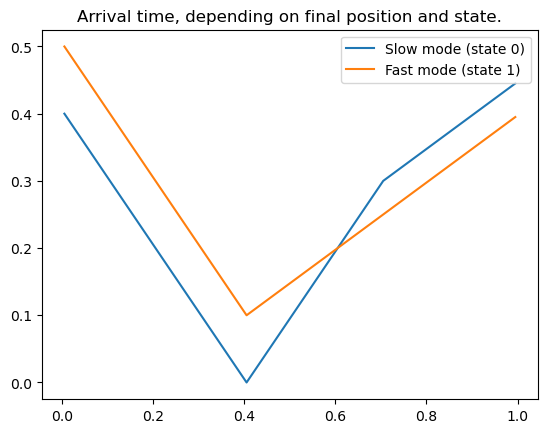

In [35]:
plt.title("Arrival time, depending on final position and state.")
plt.plot(X,hfmOut['values'][:,0],label="Slow mode (state 0)")
plt.plot(X,hfmOut['values'][:,1],label="Fast mode (state 1)")
plt.legend();

The vehicle starts in slow mode ($state = 0$). When the objective is to go forward, with a target point in slow mode $state=0$, there are two possible strategies : either remain in slow mode (best when target is close), or travel in fast mode, which costs two state transitions (best when target is far).

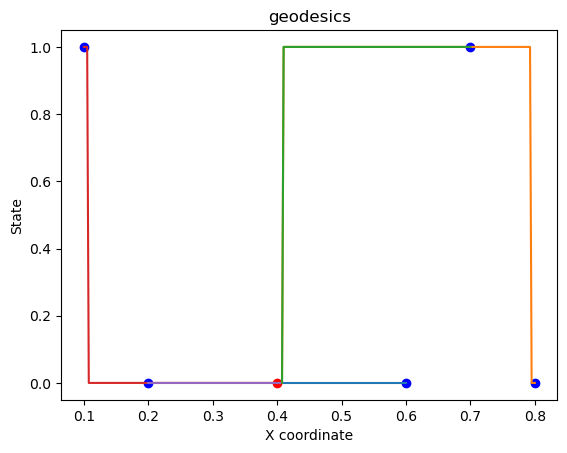

In [36]:
plt.title('geodesics')
plt.xlabel('X coordinate')
plt.ylabel('State')
plt.scatter(*hfmIn['seed'],color='red')
plt.scatter(*hfmIn['tips'].T,color='blue')
for geo in hfmOut['geodesics']: plt.plot(*geo)

## 2. The Dubins model

### 2.1 Reproducing the standard Dubins car

The configuration space of the standard Dubins car is $\bR^2 \times \bS^1$. In particular, we need to impose periodic boundary conditions on the thrid axis. The standard Dubins car also has a single state.

In [37]:
# Reproducing the Dubins2 model
Wx = 1.5 # The physical domain is the square [-Wx,Wx]^2
Nx = 201 # Number of discretization points along each physical space axis
Nθ = 64 # Number of discretization points in the angular domain
ξ = 0.3 # Turning radius
tips = [(np.cos(t),np.sin(t),0) for t in np.linspace(0,2*np.pi,21,endpoint=False)[::2]]

hfmIn = Eikonal.dictIn({
    'model':'DubinsState4',
    'speed':1,
    'seed':(0,0,0,0),
    'tips':[(*tip,0) for tip in tips],
    'dims':(Nx,Nx, Nθ,1),
    'origin':(-Wx,-Wx, -np.pi/Nθ,-0.5),
    'gridScales':(2*Wx/Nx,2*Wx/Nx, 2*np.pi/Nθ,1),
    'periodic':[False,False,True,False], # Domain = R^2 x S^1 x A
    'exportActiveNeighs':True,
    })

The Dubins car has a single state, and two two controls : one to move forward and turn left, and one to move forward and turn right. 

In [38]:
def DubinsControls(θ,ξ):
    """The controls and (vanishing) state transition costs of the Dubins car"""
    return xp.array([
    (np.cos(Θ),np.sin(Θ), np.ones_like(Θ)/ξ), # Move forward and turn left
    (np.cos(Θ),np.sin(Θ),-np.ones_like(Θ)/ξ), # Move forward and turn right
    ])[...,np.newaxis]

In [39]:
_,_,Θ,_ = hfmIn.Axes() 
# _,_,Θ,_ = hfmIn.Grid()[...,0] # Alternatively : controls depending on all the coordinates
hfmIn['controls'] = DubinsControls(Θ,ξ)
hfmIn['state_transition_costs'] = [[0]]
hfmIn['dims']=(Nx,Nx, Nθ,1)

In [40]:
hfmIn['controls'].shape

(2, 3, 64, 1)

In [41]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.1160285472869873 seconds, and 172 iterations.
Post-Processing


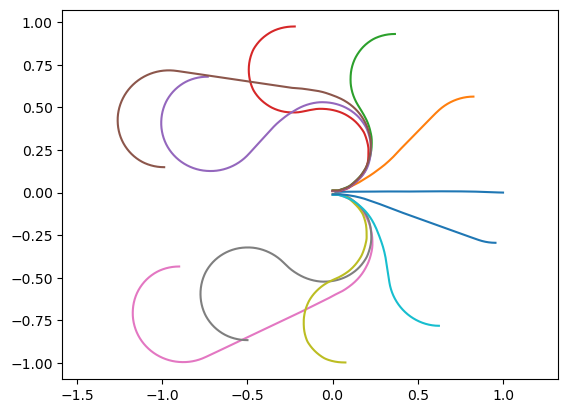

In [42]:
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1]) 
plt.axis('equal');

Let us compare with the original implementation of the Dubins car. 

In [43]:
DubinsIn = Eikonal.dictIn({
    'model':'Dubins2',
    'speed':1,
    'seed':(0,0,0),
    'tips':tips,
    'xi':ξ,
    })
DubinsIn.SetRect(sides=[[-Wx,Wx],[-Wx,Wx]],dimx=Nx) # Physical domain
DubinsIn.nTheta = Nθ

In [44]:
DubinsOut = DubinsIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.12152624130249023 seconds, and 114 iterations.
Post-Processing


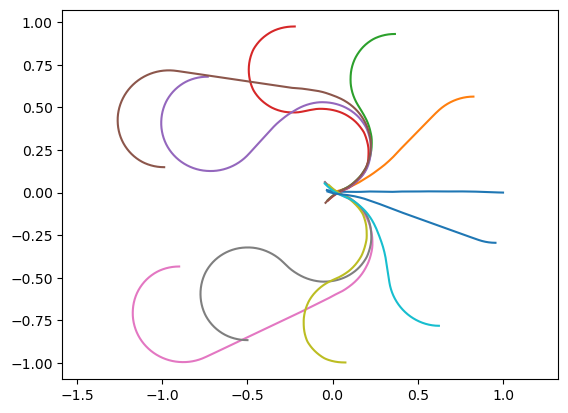

In [45]:
for geo in DubinsOut['geodesics']:  plt.plot(geo[0],geo[1]) 
plt.axis('equal');

We show below the optimal control used by the Dubins car along its trajectories, at the point obtained by rounding coordinates.
This illustrates the fact that one control is used to turn right, and another to turn left.

Straight segments are archieved by alternating left and right turns quickly. (This can be seen as quickly alternating colors on some trajectories, although not all.) 

In [46]:
optimal_control = control_source(hfmOut['activeNeighs'],len(hfmIn['controls']))

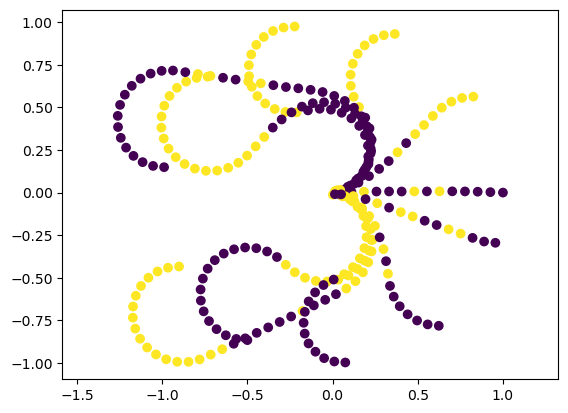

In [47]:
plt.axis('equal')
for geo in hfmOut['geodesics']:
    geo = geo[:,::20]
    igeo,_ = hfmIn.IndexFromPoint(geo.T)
    cgeo = optimal_control[igeo[:,0],igeo[:,1],igeo[:,2],igeo[:,3]]
    plt.scatter(geo[0],geo[1],c=cgeo, vmin=0,vmax=1)

### 2.2 A Dubins car with a reverse gear, and a fast forward gear

The Dubins car can only move forward, but this constraint is more sensible for a plane, than for a car. Here we extend the Dubins car with a reverse gear, and also add the possibility to move forward fast.

*However*, changing from forward to reverse gear should have a positive cost. Otherwise, the car would have the possibility to rotate in place by quickly alternating controls, for instance : turn right forward / turn left backward. 
The resulting model would behave rather similarly to the *Reeds-Shepp model*, which is appropriate for e.g. a wheelchair and is also implemented in the agd library. Here we want to avoid this behavior.

In [48]:
def DubinsReversibleControls(Θ,ξ,rev_ratio=0.5):
    controls0 = xp.array([ # Forward gear mode
        (np.cos(Θ),np.sin(Θ), np.ones_like(Θ)/ξ), # Move forward and turn left
        (np.cos(Θ),np.sin(Θ),-np.ones_like(Θ)/ξ), # Move forward and turn right
        (2*np.cos(Θ),2*np.sin(Θ),np.zeros_like(Θ)), # Move forward, quickly
    ])
    controls1 = -rev_ratio*controls0 # Reverse gear mode, which is slower
    return np.stack((controls0,controls1),axis=-1)

In [49]:
hfmIn['dims']=(Nx,Nx,Nθ,2)
hfmIn['state_transition_costs'] = [[0,0.1],[0.1,0]] #Cost of changing from forward to reverse gear
hfmIn['controls'] = DubinsReversibleControls(Θ,ξ,rev_ratio=0.35)

In [50]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.31653618812561035 seconds, and 185 iterations.
Post-Processing


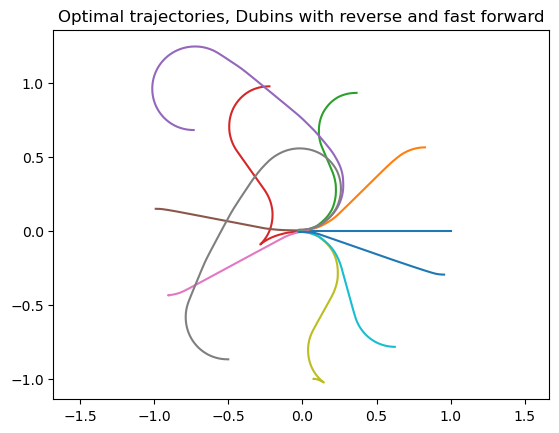

In [51]:
plt.title('Optimal trajectories, Dubins with reverse and fast forward')
plt.axis('equal')
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1]) 

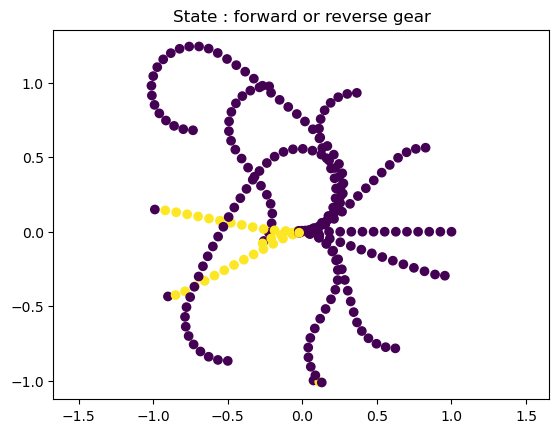

In [52]:
plt.title('State : forward or reverse gear')
plt.axis('equal')
for geo in hfmOut['geodesics']:  
    geo = geo[:,::20]
    plt.scatter(geo[0],geo[1],c=geo[3]) 

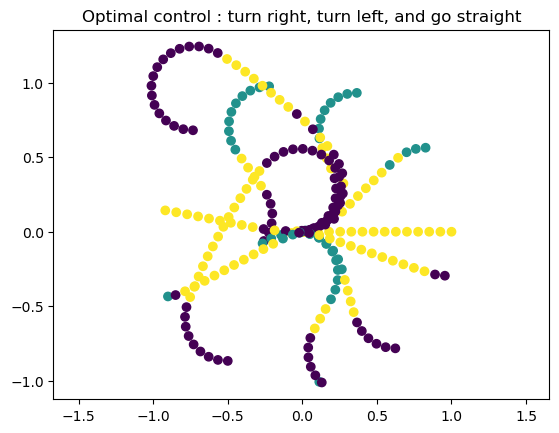

In [53]:
optimal_control,jump_source = control_source(hfmOut['activeNeighs'],len(hfmIn['controls']))

plt.title("Optimal control : turn right, turn left, and go straight")
plt.axis('equal')
for geo in hfmOut['geodesics']:
    geo = geo[:,::20]
    igeo,_ = hfmIn.IndexFromPoint(geo.T)
    cgeo = optimal_control[igeo[:,0],igeo[:,1],igeo[:,2],igeo[:,3]]
    plt.scatter(geo[0],geo[1],c=cgeo,vmin=0,vmax=2)

### 2.3 A Dubins car with sideways motions

This demo is inspired by discussions with Julien Pascal, Benoit Thuilot and Paul Chechin, on the control of vehicles with two steering trains.

Denote by $\psi$ the angle of the front steering train, by $\psi$ the angle of the back steering train, by $V$ the physical speed of the vehicle, and by $\xi$ its length. Then in the configuration space $(x,\theta) \in \Omega \times \bS^1$ the vehicle has velocity:
$$
    V (\cos(\theta+\psi),\sin(\theta+\psi), (\tan\phi-\tan\psi)/\xi).
$$
We denoted by $x$ the center of the back steering train, and by $\theta$ the orientation of the vehicle.

The following steering train configurations can be considered:
* $\phi = \psi$, the vehicle moves sideways, parallel to itself.
* $\phi = -\psi$, the vehicle makes a sharp turn, with the back steering train 'drifting'.
* $\phi$ arbitrary, $\psi = 0$, conventional Dubins car.



In [54]:
def DubinsSidewaysControls(θ,ξ,ϕ_max=np.pi/6,ψ_max=np.pi/6,rev_ratio=0.5):
    zero,one = np.zeros_like(Θ),np.ones_like(Θ)
    controls0 = xp.array([ # Fast forward, using a single steering train, 
        (np.cos(Θ),np.sin(Θ), np.tan(ϕ_max)/ξ*one), # Move forward and turn left
        (np.cos(Θ),np.sin(Θ),-np.tan(ϕ_max)/ξ*one), # Move forward and turn right
        (2*np.cos(Θ),2*np.sin(Θ),zero), # Move forward, quickly
        (zero,zero,zero), # Dummy control, to have the same number for each state
    ])
    controls1 = 0.5*xp.array([ # Slow forward, using the two steering trains
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),( np.tan(ϕ_max)-np.tan(ψ_max))/ξ*one), # sideways left
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),(-np.tan(ϕ_max)+np.tan(ψ_max))/ξ*one), # sideways right
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),( np.tan(ϕ_max)+np.tan(ψ_max))/ξ*one), # sharp turn left
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),(-np.tan(ϕ_max)-np.tan(ψ_max))/ξ*one), # sharp turn right
    ])
    controls2 = -rev_ratio*controls1 # Very slow reverse, using the two steering trains
    return np.stack((controls0,controls1,controls2),axis=-1)

In [55]:
hfmIn['dims']=(Nx,Nx,Nθ,3)
hfmIn['state_transition_costs'] = 0.1*np.array([[0,1,1],[1,0,1],[1,1,0]])
hfmIn['controls'] = DubinsSidewaysControls(Θ,ξ)

In [56]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.4380364418029785 seconds, and 185 iterations.
Post-Processing


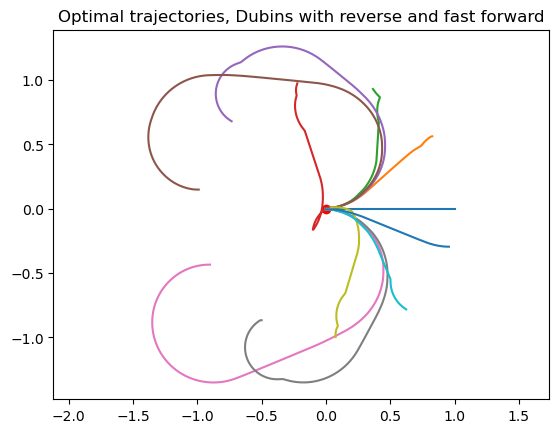

In [57]:
plt.title('Optimal trajectories, Dubins with reverse and fast forward')
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1]) 
plt.axis('equal'); plt.scatter(0,0,color='red');

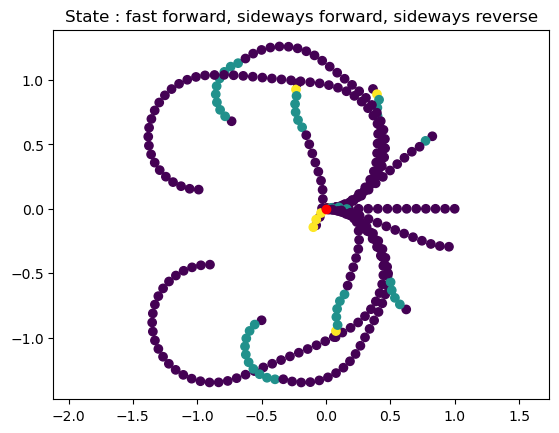

In [58]:
plt.title('State : fast forward, sideways forward, sideways reverse')
for geo in hfmOut['geodesics']: #[hfmOut['geodesics'][i] for i in [2,3]]:  
    geo = geo[:,::20]
    plt.scatter(geo[0],geo[1],c=geo[3],vmax=2)
plt.axis('equal'); plt.scatter(0,0,color='red');

### 2.4 Illustration with walls

In [59]:
walls = xp.array(0==Plotting.imread('Notebooks_FMM/TestImages/PompidouCrop.png').T,dtype=bool)
hfmIn = Eikonal.dictIn({
    'model':'DubinsState4',
    'speed':1,
    'seed':(1,5,1.,0),
    'tips':[(*tip,0) for tip in [[13,15,0],[19,14,0],[12,12,0],[17,5,0],[7,2,-3],[3,13,-1.5]]],
    'dims':(*walls.shape, Nθ,1),
    'origin':(0,0, -np.pi/Nθ,-0.5),
    'gridScales':(0.1,0.1, 2*np.pi/Nθ,1),
    'periodic':[False,False,True,False], # Domain = R^2 x S^1 x A
    'exportActiveNeighs':True,
})

In [60]:
aX0,aX1,Θ,_ = hfmIn.Axes()
X = xp.meshgrid(aX0,aX1,indexing='ij')

In [61]:
ξ=2
hfmIn['controls'] = DubinsControls(Θ,ξ)
hfmIn['state_transition_costs'] = [[0]]
hfmIn['dims']=(*walls.shape, Nθ,1)
hfmIn['walls'] = np.broadcast_to(walls[:,:,np.newaxis,np.newaxis],hfmIn.shape)

In [62]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.15151071548461914 seconds, and 307 iterations.
Post-Processing


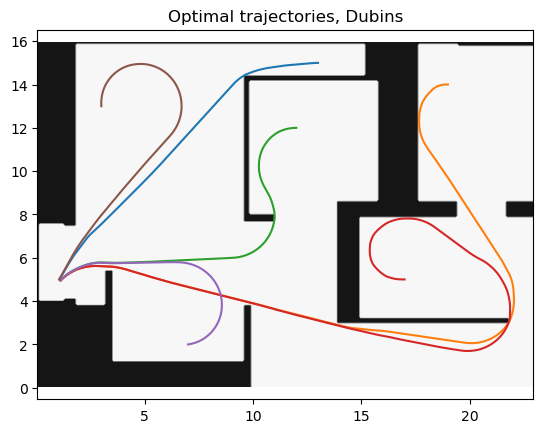

In [63]:
plt.title('Optimal trajectories, Dubins')
plt.contourf(*X,walls,cmap='Greys'); plt.axis('equal')
for geo in hfmOut['geodesics']:  plt.plot(geo[0],geo[1]) 

In [64]:
ξ=2
hfmIn['controls'] = DubinsReversibleControls(Θ,ξ)
hfmIn['state_transition_costs'] = 0.1*xp.array([[0,1],[1,0]])
hfmIn['dims']=(*walls.shape, Nθ,2)
hfmIn['walls'] = np.broadcast_to(walls[:,:,np.newaxis,np.newaxis],hfmIn.shape)

In [65]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.28253841400146484 seconds, and 317 iterations.
Post-Processing


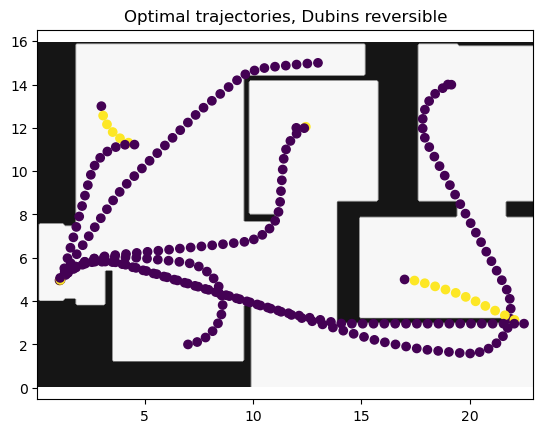

In [66]:
plt.title('Optimal trajectories, Dubins reversible')
plt.contourf(*X,walls,cmap='Greys'); plt.axis('equal')
for geo in hfmOut['geodesics']: 
    geo = geo[:,::20]
    plt.scatter(geo[0],geo[1],c=geo[3],vmax=1)

In [67]:
ξ=2
hfmIn['controls'] = DubinsSidewaysControls(Θ,ξ,rev_ratio=0.7)
hfmIn['state_transition_costs'] = 0.1*xp.array([[0,1,1],[1,0,1],[1,1,0]])
hfmIn['dims']=(*walls.shape, Nθ,3)
hfmIn['walls'] = np.broadcast_to(walls[:,:,np.newaxis,np.newaxis],hfmIn.shape)

In [68]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.3214280605316162 seconds, and 289 iterations.
Post-Processing


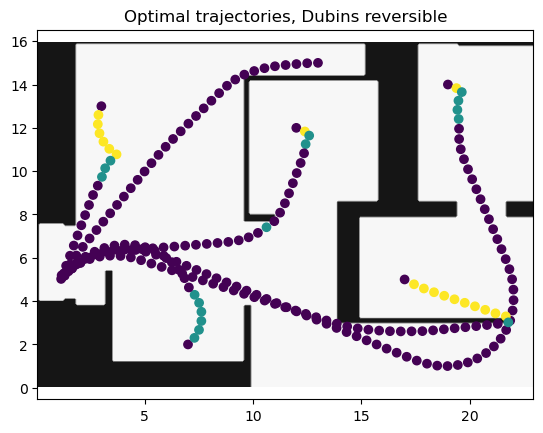

In [69]:
plt.title('Optimal trajectories, Dubins reversible')
plt.contourf(*X,walls,cmap='Greys'); plt.axis('equal')
for geo in hfmOut['geodesics']: 
    geo = geo[:,::20]
    plt.scatter(geo[0],geo[1],c=geo[3],vmax=2)

## 3. Staying away from the walls

In this section, we show how to favor paths which remain sufficiently far away from the walls, using the "fast marching squared" approach. First let us set the domain dimensions.

### 3.1 Computing the obstacles and their distance 

In [70]:
Nx = 200 # Number of points along the x-axis
Nθ = 64 # Number of points along the angular dimension
Θ = np.linspace(0,2*np.pi,Nθ,endpoint=False)

Our next step is to import the domain walls. Note that we upscale the image in order to match the dimension `Nx`.
The algorithm still works with e.g. `Nx = 100`, which does not make any upsampling, but the trajectories can be less accurate.

<!--Since the image size is quite small, and since the eikonal solver uses wide stencils, we increase a bit the resolution in order to get more accurate trajectories. (This step is optional, and the results remain ok without it here.)-->

In [71]:
from scipy import ndimage

In [72]:
walls = Plotting.imread("Notebooks_FMM/TestImages/benoit_world_zoom.png")
walls = walls[:,:,0]==0
print(f"Original image dimensions : {walls.shape}")

dx = walls.shape[0]/Nx # Distance between consecutive pixels, in original coordinates
walls = ndimage.zoom(walls.astype(float),1/dx,order=1)>0.5
print(f"Upsampled image dimensions : {walls.shape}")

# Create a coordinate system, based on the original image dimensions
X = np.meshgrid(np.arange(walls.shape[0])*dx,np.arange(walls.shape[1])*dx,indexing='ij')

Original image dimensions : (100, 100)
Upsampled image dimensions : (200, 200)


We want to favor trajectories such that the vehicle remains far from the walls, when that does not increase length too much. In addition, the vehicle should of course not intersect the walls.

Following the "fast marching squared" approach, we use the distance to the walls as the speed function.

In [73]:
walls_dist = ndimage.distance_transform_edt(np.logical_not(walls),sampling=dx)

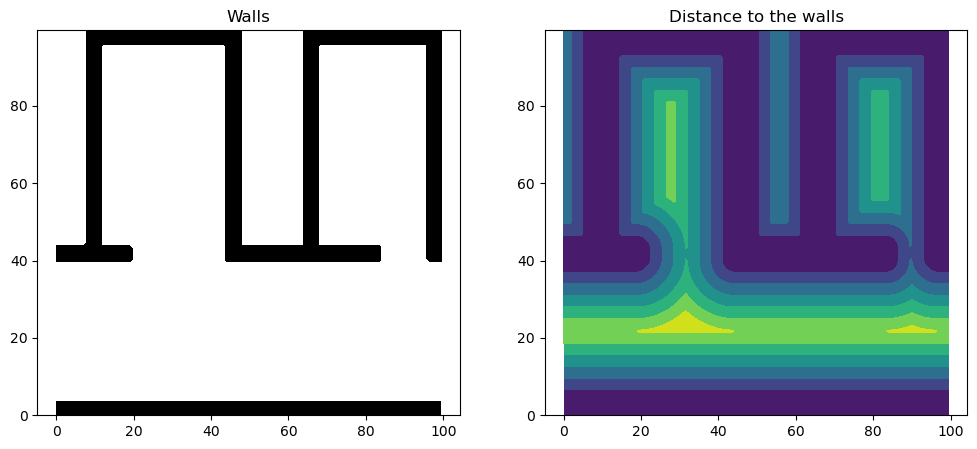

In [74]:
plt.figure(figsize=(12,5)); 
plt.subplot(1,2,1); plt.axis('equal'); plt.title("Walls")
plt.contourf(*X,walls,colors=['white','black'],levels=1);
plt.subplot(1,2,2); plt.axis('equal'); plt.title("Distance to the walls"); 
plt.contourf(*X,walls_dist);

However we do not model our vehicle as a point. Instead, we approximate it with the union of two balls, whose centers are aligned with the direction of motion. 
Note that the code below can easily adapted to account for any shape which is approximated with the union of a finite number of balls.

In [75]:
def unitvec(θ): return np.array([np.cos(θ),np.sin(θ)])
vehicle_length = 5 # Distance between the two ball centers. 
vehicle_radius = 5 # Radius of the balls. (total_length = vehicle_length+2*vehicle_radius)
walls3 = [ndimage.shift(walls_dist,-vehicle_length*unitvec(θ)/dx,order=1) for θ in Θ]
walls3 = [np.logical_or(walls_dist<vehicle_radius,w<vehicle_radius) for w in walls3]
walls3 = np.stack(walls3,axis=-1)

The three dimensional boolean array `walls3` indicates if the vehicle intersects the walls:
- for any position $(x,y)$ of the control point, which is located at the center of the rear ball.
- for any orientation $\theta$ of the vehicle, which determines the positition of the front ball.

We next compute the distance from these pseudo-walls, which will be used to favor trajectories remaining in a safe zone.

In [76]:
walls3_dist = ndimage.distance_transform_edt(np.logical_not(walls3),(dx,dx,1e10)) # Distance along spatial dims only

In [77]:
def show_vehicle(x,y,θ,**kwargs):
    """Shows an arrow from the center of the """
    c,s = vehicle_length*unitvec(θ)
    plt.scatter(x,y,28*vehicle_radius**2,color='lightblue')
    plt.scatter(x+c,y+s,28*vehicle_radius**2,color='lightblue')
    plt.arrow(x,y,c,s,width=0.5,length_includes_head=True,**kwargs)

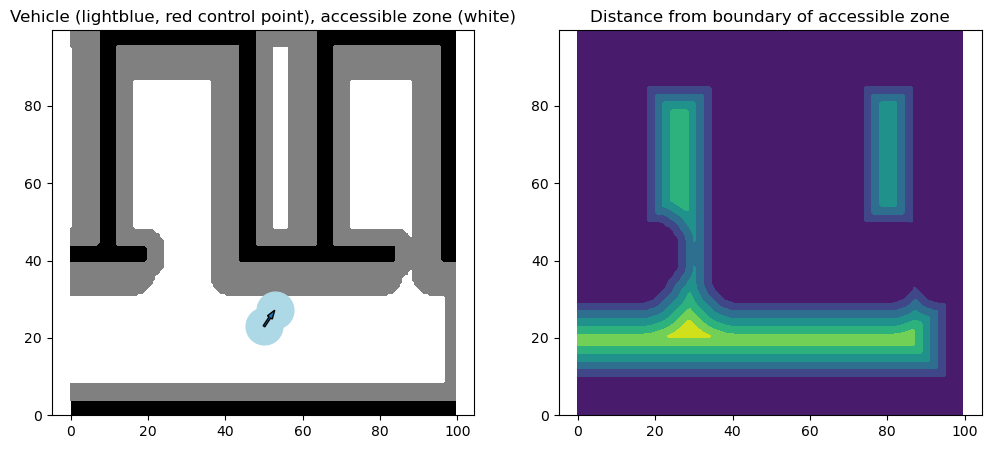

In [78]:
iθ = 10; θ = Θ[iθ] # Orientation of the vehicle
vehicle_pos = [50,23]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.axis('equal')
plt.title("Vehicle (lightblue, red control point), accessible zone (white)") 
plt.contourf(*X,walls.astype(int)+walls3[:,:,iθ],colors=['white','gray','black'],levels=2); plt.axis('equal');
show_vehicle(*vehicle_pos,θ)

plt.subplot(1,2,2); plt.axis('equal')
plt.title("Distance from boundary of accessible zone")
plt.contourf(*X,walls3_dist[:,:,iθ]);

Note that the vehicle cannot enter the room on the right unless it is well aligned with the door.

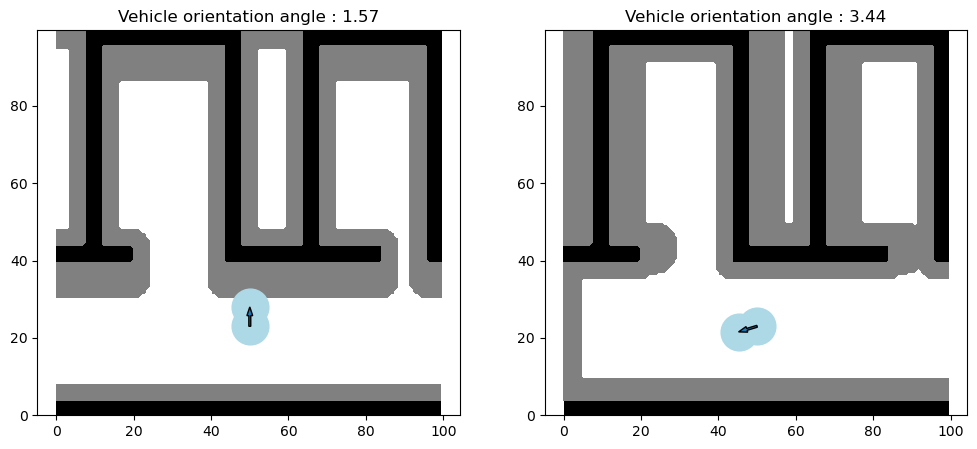

In [79]:
plt.figure(figsize=(12,5))
for i,iθ in enumerate([16,35]):
    θ=Θ[iθ]; plt.subplot(1,2,i+1); plt.axis('equal')
    plt.contourf(*X,walls.astype(int)+walls3[:,:,iθ],colors=['white','gray','black'],levels=2); plt.axis('equal');
    show_vehicle(*vehicle_pos,θ)
    plt.title(f"Vehicle orientation angle : {θ:.2f}")

*Note on the `s` argument of the scatter plotting function* : 
This argument is used to adjust the area of the displayed disk, but the underlying unit (points^2) is rather unclear. For this reason, the constant 28 was adjusted by hand, and may be system dependent.
If `vehicle_length==vehicle_radius`, then radius of the displayed disks should be equal to the distance between their centers.

### 3.2 Running the eikonal solver

We prepare the fast marching algorithm, with the correct gridscales and endpoints. The controls will be specified later.

In [80]:
hfmIn=None
hfmOut=None

In [81]:
hfmIn0 = Eikonal.dictIn({
    'model':'DubinsState4',
    'seed':[30,70,np.pi/2,0], # Compute the paths from a single seed point ...
    'tips':[[5,20,np.pi,0],[80,80,np.pi,0]], # ... to two tips points.
    'origin':(0,0, 0,-0.5),
    'gridScales':(dx,dx, 2*np.pi/Nθ,1),
    'periodic':[False,False,True,False], # Domain = R^2 x S^1 x A
    'exportActiveNeighs':True,
})

Recall that we are computing trajectories from the seed to the tips, numbered 0 and 1.

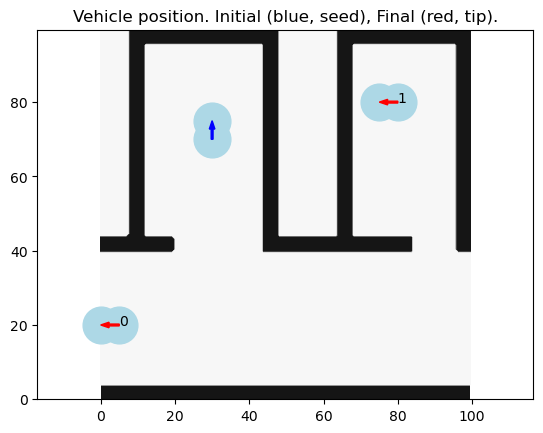

In [82]:
plt.title("Vehicle position. Initial (blue, seed), Final (red, tip).")
plt.contourf(*X,walls,cmap='Greys')
show_vehicle(*hfmIn0['seed'][:3].get(),color='blue')
for i,tip in enumerate(hfmIn0['tips']): show_vehicle(*tip[:3].get(),color='red'); plt.text(*tip[:2],i)
plt.axis('equal');

Depending on the test case, two additional arguments may be needed to tune the geodesic ODE backtracking solver:

* 'geodesic_Stationnary_delay'. There is a test in the backtracking solver ensuring that it is continually making progress toward the goal. Specifically, the path must move by at least one grid point in 'geodesic_Stationnary_delay' steps, otherwise the path is tagged as 'Stationnary', see the 'geodesic_stopping_criteria' output variable, and the solver aborts.  However, it turns out that the vehicle must do rather complex manoeuvers in some instances of this test case, while remaining almost in place, and we need to increase this value.

* 'geodesic_targetTolerance'. The backtracking solver stops when the path reaches the seed point. This parameter increases the tolerance. This is often needed when using the Dubins model with an (excessively) large turning radius.

In [83]:
def run_controls(hfmIn,controls,fm2=1.,state_transition_costs=5,verbosity=0,**kwargs):
    """
    Run the eikonal solver with the specified controls and display the results.
    - fm2 : penalize paths which come close to the walls, following the fast-marching square method.
    """
    hfmIn['controls'] = controls
    nstates = hfmIn['controls'].shape[-1]
    hfmIn['state_transition_costs'] = state_transition_costs*np.ones((nstates,nstates))
    hfmIn['dims']=(Nx,Nx, Nθ,nstates)

    # The chosen speed function which proportional to the distance to the walls.
    # Important note : the speed function must not vanish
    hfmIn['speed'] = np.broadcast_to(1+fm2*xp.array(walls3_dist)[:,:,:,np.newaxis],hfmIn.shape)
    hfmIn['walls'] = np.broadcast_to(xp.array(walls3[:,:,:,np.newaxis]),hfmIn.shape)
    hfmIn.update(verbosity=verbosity,**kwargs)
    
    hfmOut=hfmIn.Run()
    
    plt.axis('equal')
    plt.contourf(*X,walls.astype(int)+(walls_dist<vehicle_radius),colors=['white','gray','black'],levels=2)
    show_vehicle(*hfmIn0['seed'][:3].get(),color='blue')
    for i,tip in enumerate(hfmIn0['tips']): show_vehicle(*tip[:3].get(),color='red'); plt.text(*tip[:2],i)
    for i,geo in enumerate(hfmOut['geodesics']):
        plt.plot(geo[0],geo[1],label=f"rear {i}")
        plt.plot(geo[0]+vehicle_length*np.cos(geo[2]),geo[1]+vehicle_length*np.sin(geo[2]),linestyle=':',label=f"front {i}")
    plt.legend()
    return hfmIn,hfmOut

**Dubins model, with penalization of the distance to the walls.** We have the following observations : 
* the paths toward the two tips are almost undistinguishable until they leave the room containing the seed.
* the motion of the rear train (continuous line) is smoother than the motion of the front train (dotted line). Indeed, the directional wheels are on the front train, and the optimal control selection (which is the orientation of the front wheels) is typically piecewise smooth. 
* the path starts with a complex 8-shaped maneuver, used to reverse the orientation while remaining close to the center. Note our implementation penalizes the distance from the whole vehicle to the walls.

**Dubins model, without penalization.** The paths often go very close to the walls, does not go through the *middle* of the door to enter the room anymore, and the 8-shaped final maneuver disappears.

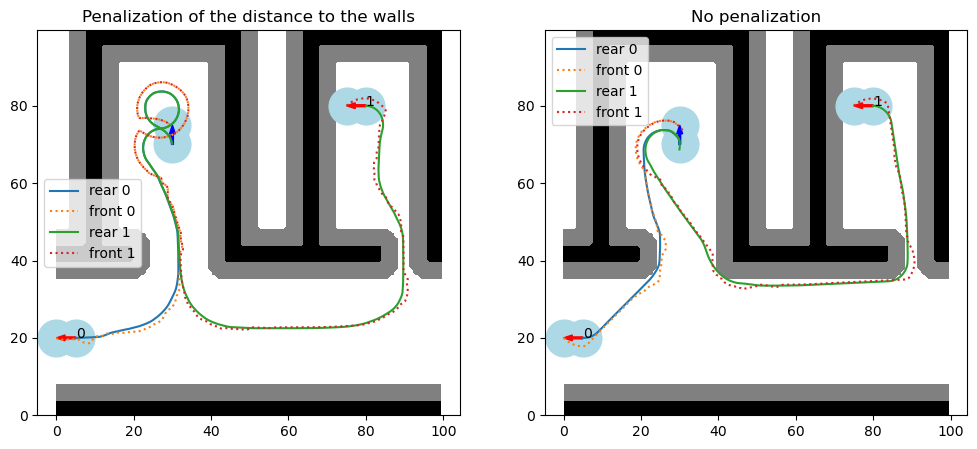

In [84]:
ξ = 5 # Typical turning radius
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.title("Penalization of the distance to the walls")
run_controls(hfmIn0.copy(),DubinsControls(Θ,ξ),verbosity=0);
plt.subplot(1,2,2); plt.title("No penalization")
run_controls(hfmIn0.copy(),DubinsControls(Θ,ξ),fm2=0,verbosity=0);

**Dubins model, large turning radius.**
The combination of an (excessively) large turning radius, in a small room, with a penalization of the distance to the walls, causes numerical difficulties : 
* The turning radius constraint seems to be somewhat violated
* The path does not start from the seed, but from a nearby point. (We had to set some tolerance for the target of the geodesic backtracking, which is the seed since backtracking goes in reverse).

The trajectory appears to be better without penalization of the distance to the walls, since the vehicle does not hesitate to take more room for the initial manoeuver. 

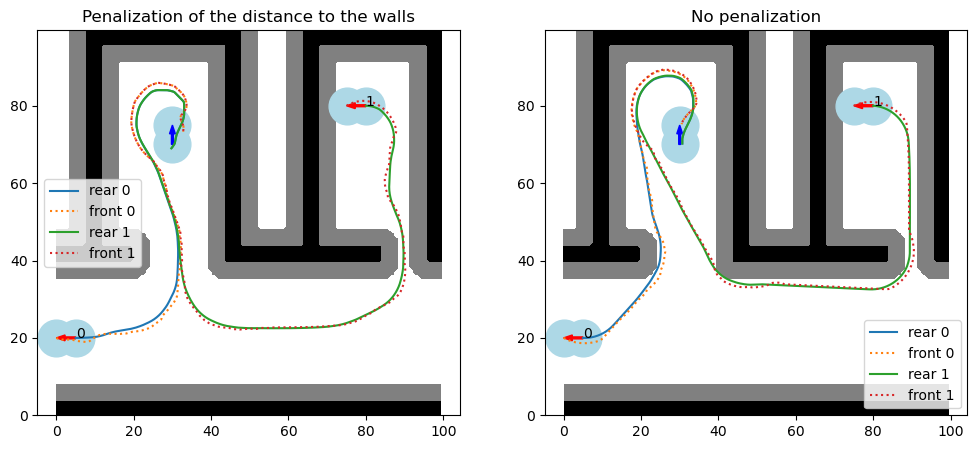

In [85]:
ξ = 10 # Typical turning radius
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.title("Penalization of the distance to the walls")
run_controls(hfmIn0.copy(),DubinsControls(Θ,ξ),geodesic_targetTolerance=10);
plt.subplot(1,2,2); plt.title("No penalization")
run_controls(hfmIn0.copy(),DubinsControls(Θ,ξ),fm2=0);

**Dubins model, with various reverse gear speeds**, and large turning radius

As seen in the last experiment, it is very hard to maneuver inside the initial room, due to lack of space. The vehicle thus exists this room in reverse gear. 

If the reverse gear is as slow, the vehicle manoeuvers into forward gear as soon as possible. If the reverse gear is as fast as the forward gear, then the vehicle postpones this manoeuver until it is nearby tip 1, which leads to a (very slightly) shorter path overall.

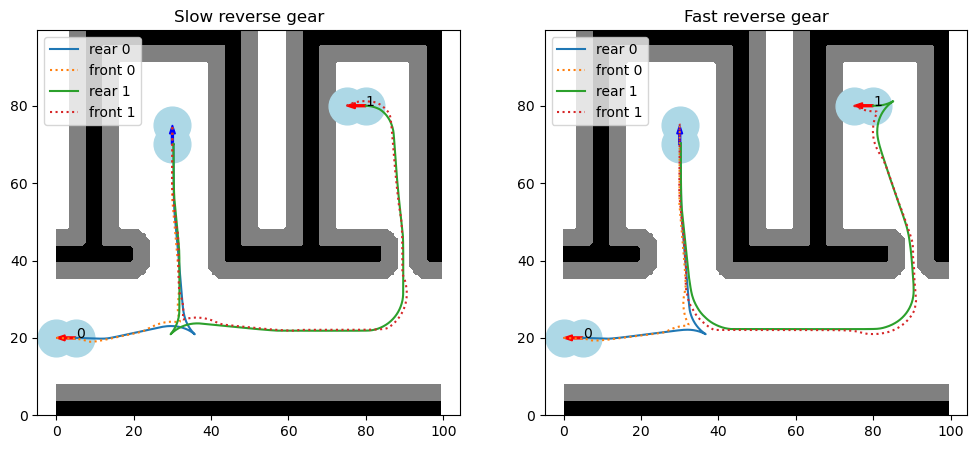

In [86]:
ξ = 10 # Typical turning radius
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.title("Slow reverse gear")
run_controls(hfmIn0.copy(),DubinsReversibleControls(Θ,ξ));
plt.subplot(1,2,2); plt.title("Fast reverse gear")
run_controls(hfmIn0.copy(),DubinsReversibleControls(Θ,ξ,rev_ratio=1));

**Dubins model, with various costs of  forward-reverse gear transition**

If the change of gear is sufficiently cheap, then the vehicle performs an additional maneuver nearby tip 1 (forward-reverse-forward), so as to adjust its parking position and remain far from the walls. 

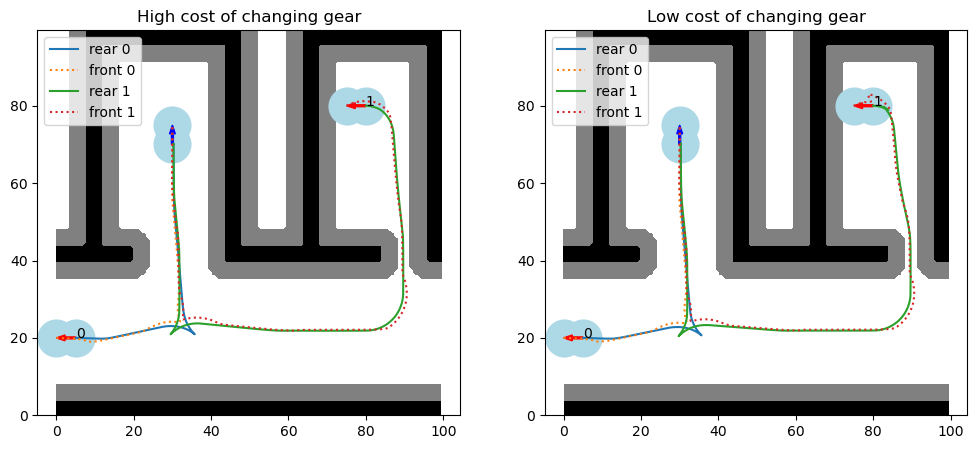

In [87]:
ξ = 10 # Typical turning radius
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.title("High cost of changing gear")
run_controls(hfmIn0.copy(),DubinsReversibleControls(Θ,ξ,rev_ratio=0.5));
plt.subplot(1,2,2); plt.title("Low cost of changing gear")
run_controls(hfmIn0.copy(),DubinsReversibleControls(Θ,ξ,rev_ratio=0.5),state_transition_costs=1);

**Dubins car with sideways motions.**
This vehicle will perform complex motions, using all available states (including sideways and reverse) so to remain far from the walls. 

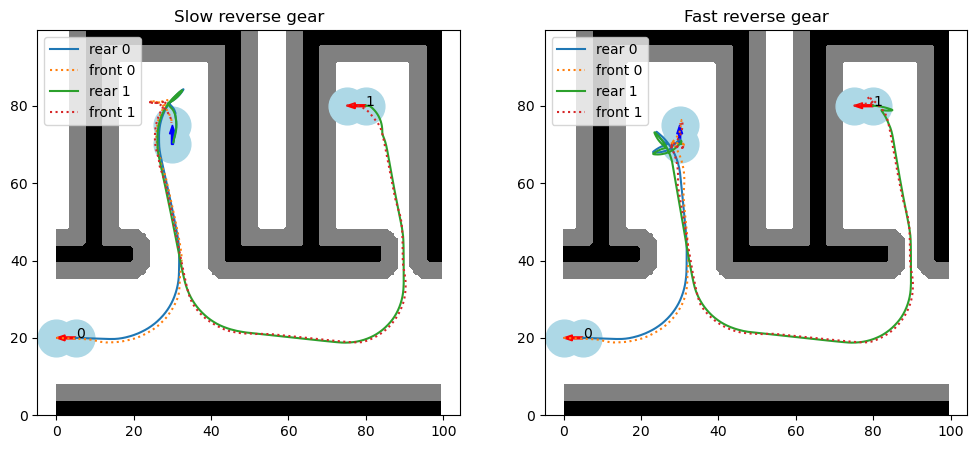

In [88]:
ξ = 10 # Typical turning radius
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.title("Slow reverse gear")
run_controls(hfmIn0.copy(),DubinsSidewaysControls(Θ,ξ));
plt.subplot(1,2,2); plt.title("Fast reverse gear")
run_controls(hfmIn0.copy(),DubinsSidewaysControls(Θ,ξ,rev_ratio=1));

**Dubins car with sideways motions.**
The trajectory is simplified if one penalizes less strongly the distance to the walls, or if the transition between the states costs more.

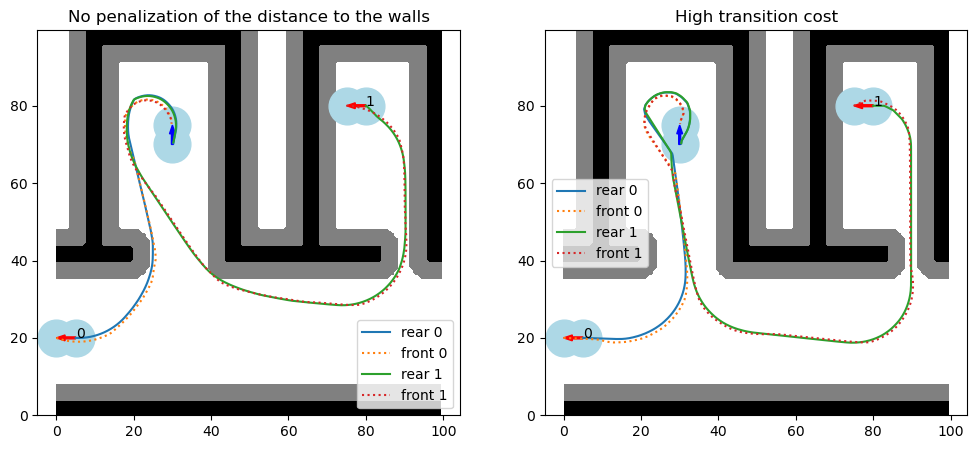

In [89]:
ξ = 10 # Typical turning radius
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.title("No penalization of the distance to the walls")
run_controls(hfmIn0.copy(),DubinsSidewaysControls(Θ,ξ),fm2=0);
plt.subplot(1,2,2); plt.title("High transition cost")
run_controls(hfmIn0.copy(),DubinsSidewaysControls(Θ,ξ),state_transition_costs=100);

### 3.3 Yet another model

The following model, proposed by collaborators, has six different states. Three are devoted to forward motion (straight, sideways, turning), and three to reverse motion symmetrically but with half speed. It is reasonnable to expect that changing from forward to reverse motion is more costly than changing between forward motion modes, hence we introduce an adequate state transition cost matrix.

<!---
from Miscellaneous.rreload import rreload
def reload_packages():
    global Eikonal
    Eikonal, = rreload((Eikonal,),rootdir="../..")
    Eikonal = ad.cupy_friendly(Eikonal)
--->

In [90]:
def DubinsSixControls(θ,ξ,ϕ_max=0.6375,ψ_max=0.6375,rev_ratio=0.5):
    """
    Controls trying to take advantage of the number of states available
    """
    zero,one = np.zeros_like(Θ),np.ones_like(Θ)
    ligne_droite_av = xp.array([
        (2*np.cos(Θ),2*np.sin(Θ),zero),
        (zero,zero,zero),
    ])
    crabe_av = xp.array([
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),( np.tan(ϕ_max)-np.tan(ψ_max))/ξ*one), # sideways left
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),(-np.tan(ϕ_max)+np.tan(ψ_max))/ξ*one), # sideways right
    ])
    turn_av = xp.array([
        (np.cos(Θ-ψ_max),np.sin(Θ-ψ_max),( np.tan(ϕ_max)+np.tan(ψ_max))/ξ*one), # sharp turn left
        (np.cos(Θ+ψ_max),np.sin(Θ+ψ_max),(-np.tan(ϕ_max)-np.tan(ψ_max))/ξ*one), # sharp turn right
    ])
    ligne_droite_ar = -rev_ratio*ligne_droite_av
    crabe_ar = -rev_ratio*crabe_av
    turn_ar = -rev_ratio*turn_av
    return np.stack((ligne_droite_av,crabe_av,turn_av,ligne_droite_ar,crabe_ar,turn_ar),axis=-1)

r=3 # Cost of changing from forward motion to backward motion.
state_transition_costs = 5*np.array([
    [0,1,1,r,r,r],
    [1,0,1,r,r,r],
    [1,1,0,r,r,r],
    [r,r,r,0,1,1],
    [r,r,r,1,0,1],
    [r,r,r,1,1,0] ]);

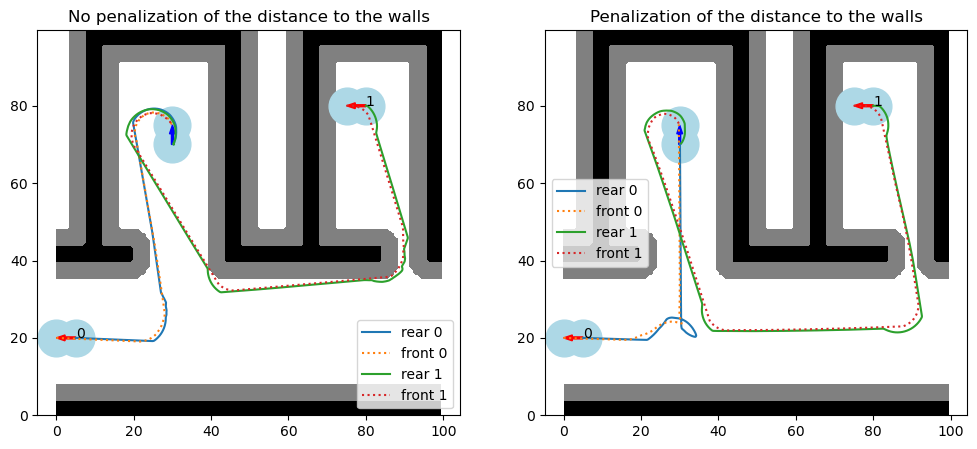

In [91]:
ξ = 10 # Typical turning radius
plt.figure(figsize=(12,5)) 
plt.subplot(1,2,1); plt.title("No penalization of the distance to the walls")
hfmIn = hfmIn0.copy(); hfmIn['tip']=hfmIn['tips'][0]
_,hfmOut1=run_controls(hfmIn0.copy(),DubinsSixControls(Θ,ξ),fm2=0,state_transition_costs=state_transition_costs);
plt.subplot(1,2,2); plt.title("Penalization of the distance to the walls")
hfmIn = hfmIn0.copy(); hfmIn['tip']=hfmIn['tips'][1]
hfmIn2,hfmOut2=run_controls(hfmIn0.copy(),DubinsSixControls(Θ,ξ),state_transition_costs=state_transition_costs);